In [3]:
# เริ่มต้นใช้งาน GEE
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

ee.Authenticate()
try:
    ee.Initialize(project="ee-sakda-451407")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-sakda-451407")

In [5]:
def calculate_ndvi(image):
    try:
        # MOD09Q1 bands: sur_refl_b01 (red), sur_refl_b02 (NIR)
        nir = image.select('sur_refl_b02').multiply(0.0001)  # Apply scale factor
        red = image.select('sur_refl_b01').multiply(0.0001)  # Apply scale factor
        
        # คำนวณ NDVI
        ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
        
        # กำหนดคุณสมบัติให้กับภาพ
        return image.addBands(ndvi).copyProperties(image, ['system:time_start'])
    except Exception as e:
        print(f"Error calculating NDVI: {e}")
        return None

# ฟังก์ชันดึงข้อมูล NDVI รายช่วง 8 วันจาก MOD09Q1
def get_8day_ndvi(start_date, end_date, study_area):
    try:
        # เรียกชุดข้อมูล MOD09Q1
        modis = ee.ImageCollection('MODIS/061/MOD09Q1') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)
        
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = modis.size().getInfo()
        print(f"จำนวนภาพ MODIS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล MOD09Q1 ในพื้นที่ศึกษา")
            return None
        
        # คำนวณ NDVI
        modis_ndvi = modis.map(calculate_ndvi)
        print(f"จำนวนภาพหลังคำนวณ NDVI: {modis_ndvi.size().getInfo()}")
        
        # เฉลี่ย NDVI เป็นรายช่วง 8 วัน
        def create_8day_composite(start_millis):
            start = ee.Date(start_millis)
            end = start.advance(8, 'day')
            composite_collection = modis_ndvi.filterDate(start, end)
            count = composite_collection.size()
            
            # สร้างภาพเฉลี่ยและกำหนดคุณสมบัติ
            composite_mean = composite_collection.mean() \
                .set('system:time_start', start_millis) \
                .set('system:index', start.format('YYYY_MM_dd'))
            
            # ตรวจสอบว่ามีข้อมูลหรือไม่
            return ee.Algorithms.If(
                count.gt(0), 
                composite_mean,
                ee.Image.constant(0).rename('NDVI') \
                    .set('system:time_start', start_millis) \
                    .set('system:index', start.format('YYYY_MM_dd'))
            )
        
        # สร้างรายการวันเริ่มต้นของแต่ละช่วง 8 วัน
        start_dates = ee.List.sequence(
            ee.Date(start_date).millis(),
            ee.Date(end_date).millis(),
            8 * 24 * 60 * 60 * 1000  # 8 วันในหน่วยมิลลิวินาที
        )
        
        # สร้าง ImageCollection
        composite_images = start_dates.map(create_8day_composite)
        composites_8day = ee.ImageCollection.fromImages(composite_images)
        
        print(f"จำนวนช่วง 8 วันทั้งหมด: {composites_8day.size().getInfo()}")
        
        return composites_8day.select('NDVI')
    except Exception as e:
        print(f"Error getting 8-day NDVI: {e}")
        return None

# ฟังก์ชันดึงข้อมูล Hotspot รายช่วง 8 วันจาก FIRMS - แก้ไขให้ดึง T21
def get_8day_hotspots(start_date, end_date, study_area):
    try:
        # เรียกชุดข้อมูล FIRMS
        firms = ee.ImageCollection('FIRMS') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area) \
            .select(['T21', 'confidence'])  # เลือกทั้งอุณหภูมิและความเชื่อมั่น
        
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = firms.size().getInfo()
        print(f"จำนวนภาพ FIRMS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล FIRMS ในพื้นที่ศึกษา")
            return None
        
        # รวม hotspot เป็นรายช่วง 8 วัน
        def create_8day_hotspot_composite(start_millis):
            start = ee.Date(start_millis)
            end = start.advance(8, 'day')
            composite_collection = firms.filterDate(start, end)
            count = composite_collection.size()
            
            # คำนวณค่าเฉลี่ย T21 และจำนวน hotspot
            composite_mean = composite_collection.mean() \
                .set('system:time_start', start_millis) \
                .set('system:index', start.format('YYYY_MM_dd'))
            
            # เพิ่ม band สำหรับจำนวน hotspot
            hotspot_count_band = ee.Image.constant(count).rename('hotspot_count')
            composite_with_count = composite_mean.addBands(hotspot_count_band)
            
            return ee.Algorithms.If(
                count.gt(0), 
                composite_with_count,
                ee.Image.constant([0, 0]).rename(['T21', 'hotspot_count']) \
                    .set('system:time_start', start_millis) \
                    .set('system:index', start.format('YYYY_MM_dd'))
            )
        
        # สร้างรายการวันเริ่มต้นของแต่ละช่วง 8 วัน
        start_dates = ee.List.sequence(
            ee.Date(start_date).millis(),
            ee.Date(end_date).millis(),
            8 * 24 * 60 * 60 * 1000  # 8 วันในหน่วยมิลลิวินาที
        )
        
        # สร้าง ImageCollection
        composite_images = start_dates.map(create_8day_hotspot_composite)
        composites_8day = ee.ImageCollection.fromImages(composite_images)
        
        print(f"จำนวนช่วง 8 วันที่มี hotspot: {composites_8day.size().getInfo()}")
        
        return composites_8day.select(['T21', 'hotspot_count'])
    except Exception as e:
        print(f"Error getting 8-day hotspots: {e}")
        return None

# ฟังก์ชันสร้างข้อมูลรวม - แก้ไขให้รวม T21 และ hotspot_count
def create_dataset(ndvi_collection, hotspot_collection, study_area):
    try:
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        if ndvi_collection is None:
            print("ข้อมูล NDVI เป็น None")
            return None
            
        ndvi_size = ndvi_collection.size().getInfo()
        print(f"NDVI collection size: {ndvi_size}")
        
        if ndvi_size == 0:
            print("ไม่มีข้อมูล NDVI")
            return None
        
        # ใช้วันที่ของ NDVI เป็นหลัก
        ndvi_times = ndvi_collection.aggregate_array('system:time_start')
        print(f"จำนวนช่วงเวลาที่มีข้อมูล NDVI: {ndvi_times.size().getInfo()}")
        
        # ฟังก์ชันสำหรับรวมข้อมูลแต่ละช่วง 8 วัน
        def combine_8day_data(time_start):
            # กรองข้อมูล NDVI ตามเวลา
            ndvi_image = ndvi_collection.filter(ee.Filter.eq('system:time_start', time_start)).first()
            
            # หา hotspot ในช่วง 8 วันที่ตรงกับ NDVI
            start_date = ee.Date(time_start)
            end_date = start_date.advance(8, 'day')
            
            # ดึงข้อมูล FIRMS ในช่วงเวลาเดียวกับ NDVI
            firms_in_period = ee.ImageCollection('FIRMS') \
                .filterDate(start_date, end_date) \
                .filterBounds(study_area) \
                .select('T21')
            
            # คำนวณค่าเฉลี่ย T21 และนับจำนวน hotspot
            hotspot_count = firms_in_period.size()
            
            # สร้างภาพที่มี hotspot count และ mean T21
            mean_t21 = firms_in_period.mean()
            hotspot_count_image = ee.Image.constant(hotspot_count).rename('hotspot_count')
            
            # กำหนดค่าเริ่มต้นสำหรับ T21 ถ้าไม่มีข้อมูล
            mean_t21_filled = ee.Algorithms.If(
                hotspot_count.gt(0),
                mean_t21,
                ee.Image.constant(0).rename('T21')
            )
            
            # รวมภาพ
            combined_image = ndvi_image \
                .addBands(ee.Image(mean_t21_filled)) \
                .addBands(hotspot_count_image)
            
            # ลดขนาดข้อมูลเป็นค่าเฉลี่ยของพื้นที่ศึกษา
            reduced = combined_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=study_area,
                scale=1000,  # 1km resolution
                maxPixels=1e9
            )
            
            # สร้าง Feature พร้อมวันที่
            date_str = ee.Date(time_start).format('YYYY-MM-dd')
            return ee.Feature(None, reduced.set('date', date_str))
        
        # แปลงเป็น FeatureCollection โดยใช้เวลาของ NDVI
        if ndvi_times.size().getInfo() > 0:
            combined_fc = ee.FeatureCollection(ndvi_times.map(combine_8day_data))
            return combined_fc
        else:
            print("ไม่มีข้อมูล NDVI")
            return None
            
    except Exception as e:
        print(f"Error creating dataset: {e}")
        return None

# ฟังก์ชันแปลง FeatureCollection เป็น DataFrame - แก้ไขให้รองรับ T21
def fc_to_df(fc):
    try:
        # ดึงข้อมูลจาก GEE
        features = fc.getInfo()['features']
    except Exception as e:
        print("ไม่สามารถดึงข้อมูลจาก GEE ได้:", str(e))
        return pd.DataFrame()
    
    # สร้าง dictionary สำหรับเก็บข้อมูล
    data_dict = {'date': [], 'NDVI': [], 'T21': [], 'hotspot_count': []}
    
    for feature in features:
        props = feature['properties']
        if 'NDVI' in props and props['NDVI'] is not None:
            data_dict['date'].append(props.get('date', ''))
            data_dict['NDVI'].append(props.get('NDVI', 0))
            data_dict['T21'].append(props.get('T21', 0))
            data_dict['hotspot_count'].append(props.get('hotspot_count', 0))
    
    # สร้าง DataFrame
    df = pd.DataFrame(data_dict)
    
    # แปลงคอลัมน์ date เป็น datetime
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
        df.sort_values('date', inplace=True)
    
    return df

# ฟังก์ชันเตรียมข้อมูลสำหรับการฝึกแบบจำลอง - แก้ไขให้ใช้ T21 หรือ hotspot_count ได้
def prepare_training_data(df, sequence_length=4, target_column='T21'):
    # ตรวจสอบว่ามีข้อมูลหรือไม่
    if df.empty:
        raise ValueError("ไม่มีข้อมูลใน DataFrame")
    
    print(f"จำนวนข้อมูลดิบ: {len(df)}")
    print(f"คอลัมน์ที่มี: {df.columns.tolist()}")
    print(f"ตัวอย่างข้อมูล:\n{df.head()}")
    
    # ล้างข้อมูลที่ขาดหาย
    df_cleaned = df.fillna(0)  # เปลี่ยนจาก dropna() เป็น fillna(0)
    print(f"จำนวนข้อมูลหลังล้าง: {len(df_cleaned)}")
    print(f"ค่าสถิติพื้นฐาน:\n{df_cleaned.describe()}")
    
    # ตรวจสอบว่ามีข้อมูลเพียงพอหลังจากล้างข้อมูล
    min_required = sequence_length + 5
    if len(df_cleaned) < min_required:
        raise ValueError(f"ข้อมูลไม่เพียงพอสำหรับการสร้างลำดับ ต้องการอย่างน้อย {min_required} ข้อมูล แต่มีเพียง {len(df_cleaned)}")
    
    # ตรวจสอบคอลัมน์ที่มีอยู่และเลือกเป็น target
    available_targets = ['T21', 'hotspot_count']
    selected_target = None
    
    for target in available_targets:
        if target in df_cleaned.columns:
            selected_target = target
            print(f"ใช้ {target} เป็น target variable")
            break
    
    if selected_target is None:
        raise ValueError(f"ไม่พบคอลัมน์ target ใดๆ ในข้อมูล ตรวจสอบคอลัมน์ที่มี: {df_cleaned.columns.tolist()}")
    
    # เตรียมข้อมูล feature และ target
    feature_columns = ['NDVI']
    if selected_target == 'T21' and 'hotspot_count' in df_cleaned.columns:
        feature_columns.append('hotspot_count')
    elif selected_target == 'hotspot_count' and 'T21' in df_cleaned.columns:
        feature_columns.append('T21')
    
    X = df_cleaned[feature_columns].values
    y = df_cleaned[[selected_target]].values
    
    print(f"Features ที่ใช้: {feature_columns}")
    print(f"Target ที่ใช้: {selected_target}")
    
    # ปรับขนาดข้อมูล
    from sklearn.preprocessing import StandardScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    # สร้างลำดับข้อมูลสำหรับ LSTM
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y_scaled[i+sequence_length])
    
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    
    print(f"จำนวนลำดับที่สร้างได้: {len(X_seq)}")
    print(f"รูปร่างข้อมูล X: {X_seq.shape}, y: {y_seq.shape}")
    
    return X_seq, y_seq, scaler_x, scaler_y

# ฟังก์ชันสร้างแบบจำลอง LSTM
def create_lstm_model(sequence_length, n_features):
    """สร้างแบบจำลอง LSTM สำหรับทำนาย hotspot"""
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from tensorflow.keras.optimizers import Adam
        
        model = Sequential()
        
        # LSTM layers
        model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features)))
        model.add(Dropout(0.2))
        
        model.add(LSTM(32, return_sequences=False))
        model.add(Dropout(0.2))
        
        # Output layer
        model.add(Dense(1))
        
        model.compile(optimizer=Adam(learning_rate=0.001), 
                      loss='mse', 
                      metrics=['mae'])
        
        return model
    except ImportError:
        print("ไม่สามารถ import TensorFlow ได้ กรุณาติดตั้ง TensorFlow ก่อน")
        return None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างแบบจำลอง: {e}")
        return None

# ฟังก์ชันสร้างแบบจำลอง CNN-LSTM
def create_cnn_lstm_model(sequence_length, n_features):
    """สร้างแบบจำลอง CNN-LSTM สำหรับทำนาย hotspot"""
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
        from tensorflow.keras.optimizers import Adam
        
        model = Sequential()
        
        # CNN layers - ใช้ Conv1D แทน Conv2D
        model.add(Conv1D(filters=32, kernel_size=2, activation='relu', 
                         input_shape=(sequence_length, n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.2))
        
        # LSTM layers
        model.add(LSTM(32, return_sequences=False))
        model.add(Dropout(0.2))
        
        # Output layer
        model.add(Dense(1))
        
        model.compile(optimizer=Adam(learning_rate=0.001), 
                      loss='mse', 
                      metrics=['mae'])
        
        return model
    except ImportError:
        print("ไม่สามารถ import TensorFlow ได้ กรุณาติดตั้ง TensorFlow ก่อน")
        return None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างแบบจำลอง CNN-LSTM: {e}")
        return None

# ฟังก์ชันประเมินผลแบบจำลอง
def evaluate_model(y_true, y_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')
    
    return mse, mae, r2

# ฟังก์ชันสร้างกราฟการเรียนรู้ (Learning Curves)
def plot_learning_curves(history):
    """แสดงกราฟ loss และ accuracy ระหว่างการฝึก"""
    try:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # กราฟ Loss
        axes[0].plot(history.history['loss'], label='Training Loss', color='blue')
        if 'val_loss' in history.history:
            axes[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
        axes[0].set_title('Model Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # กราฟ MAE
        axes[1].plot(history.history['mae'], label='Training MAE', color='blue')
        if 'val_mae' in history.history:
            axes[1].plot(history.history['val_mae'], label='Validation MAE', color='red')
        axes[1].set_title('Model MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟการเรียนรู้: learning_curves.png")
        
    except ImportError:
        print("ไม่สามารถ import matplotlib ได้ กรุณาติดตั้ง matplotlib")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟการเรียนรู้: {e}")

# ฟังก์ชันเปรียบเทียบ y_test กับ y_predict
def plot_prediction_comparison(y_true, y_pred, title="Actual vs Predicted"):
    """แสดงกราฟเปรียบเทียบค่าจริงกับค่าทำนาย"""
    try:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # กราฟเส้น Time Series
        axes[0].plot(range(len(y_true)), y_true, label='Actual', color='blue', marker='o', markersize=4)
        axes[0].plot(range(len(y_pred)), y_pred, label='Predicted', color='red', marker='s', markersize=4)
        axes[0].set_title(f'{title} - Time Series')
        axes[0].set_xlabel('Data Point')
        axes[0].set_ylabel('Value')
        axes[0].legend()
        axes[0].grid(True)
        
        # กราฟ Scatter Plot
        axes[1].scatter(y_true, y_pred, alpha=0.7, color='green')
        # เส้น y=x สำหรับการเปรียบเทียบ
        min_val = min(min(y_true), min(y_pred))
        max_val = max(max(y_true), max(y_pred))
        axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
        axes[1].set_title(f'{title} - Scatter Plot')
        axes[1].set_xlabel('Actual Values')
        axes[1].set_ylabel('Predicted Values')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.savefig('prediction_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟเปรียบเทียบ: prediction_comparison.png")
        
    except ImportError:
        print("ไม่สามารถ import matplotlib ได้ กรุณาติดตั้ง matplotlib")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟเปรียบเทียบ: {e}")

# ฟังก์ชันแสดงกราฟทำนาย 8 วันต่อจากข้อมูลจริง
def plot_future_prediction(df, prediction_value, sequence_length=4):
    """แสดงกราฟข้อมูลจริงและการทำนาย 8 วันถัดไป"""
    try:
        import matplotlib.pyplot as plt
        
        # ตรวจสอบคอลัมน์ target ที่มีอยู่
        target_col = None
        if 'T21' in df.columns:
            target_col = 'T21'
        elif 'hotspot_count' in df.columns:
            target_col = 'hotspot_count'
        else:
            print("ไม่พบคอลัมน์ target สำหรับการแสดงกราฟ")
            return
            
        # เตรียมข้อมูล
        last_date = df['date'].iloc[-1]
        future_date = last_date + timedelta(days=8)
        
        # สร้าง DataFrame สำหรับการทำนาย
        future_df = pd.DataFrame({
            'date': [future_date],
            target_col: [prediction_value]
        })
        
        # รวมข้อมูล
        combined_df = pd.concat([df[['date', target_col]], future_df], ignore_index=True)
        
        # สร้างกราฟ
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        # แสดงข้อมูลจริง
        ax.plot(df['date'], df[target_col], 
               label=f'Actual {target_col}', color='blue', marker='o', markersize=4, linewidth=2)
        
        # แสดงข้อมูลช่วงล่าสุดที่ใช้ทำนาย
        recent_data = df[['date', target_col]].tail(sequence_length)
        ax.plot(recent_data['date'], recent_data[target_col], 
               label=f'Recent {sequence_length} periods (used for prediction)', 
               color='orange', marker='s', markersize=6, linewidth=3)
        
        # แสดงการทำนาย
        ax.scatter([future_date], [prediction_value], 
                  color='red', s=100, marker='*', zorder=5, 
                  label=f'Predicted {target_col} (8 days ahead)')
        
        # เชื่อมเส้นจากข้อมูลล่าสุดไปยังการทำนาย
        ax.plot([df['date'].iloc[-1], future_date], 
               [df[target_col].iloc[-1], prediction_value], 
               '--', color='red', alpha=0.7, linewidth=2)
        
        # ปรับแต่งกราฟ
        ax.set_title(f'{target_col} Prediction - 8 Days Ahead', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel(f'{target_col} Value', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # ปรับแกน x
        plt.xticks(rotation=45)
        
        # เพิ่มข้อความแสดงค่าทำนาย
        ax.annotate(f'Predicted: {prediction_value:.2f}', 
                   xy=(future_date, prediction_value), 
                   xytext=(10, 20), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        plt.tight_layout()
        plt.savefig('future_prediction.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟทำนาย: future_prediction.png")
        
    except ImportError:
        print("ไม่สามารถ import matplotlib ได้ กรุณาติดตั้ง matplotlib")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟทำนาย: {e}")

# ฟังก์ชันแสดงกราฟรวมทั้งหมด
def create_comprehensive_plots(history, y_test_rescaled, y_pred_rescaled, df, prediction_value):
    """สร้างกราฟรวมทั้งหมดในหน้าเดียว"""
    try:
        import matplotlib.pyplot as plt
        
        fig = plt.figure(figsize=(20, 15))
        
        # กราฟ 1: Learning Curves
        ax1 = plt.subplot(2, 3, 1)
        ax1.plot(history.history['loss'], label='Training Loss', color='blue')
        if 'val_loss' in history.history:
            ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # กราฟ 2: MAE
        ax2 = plt.subplot(2, 3, 2)
        ax2.plot(history.history['mae'], label='Training MAE', color='blue')
        if 'val_mae' in history.history:
            ax2.plot(history.history['val_mae'], label='Validation MAE', color='red')
        ax2.set_title('Training MAE')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE')
        ax2.legend()
        ax2.grid(True)
        
        # กราฟ 3: Actual vs Predicted (Time Series)
        ax3 = plt.subplot(2, 3, 3)
        ax3.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual', color='blue', marker='o')
        ax3.plot(range(len(y_pred_rescaled)), y_pred_rescaled, label='Predicted', color='red', marker='s')
        ax3.set_title('Test Data: Actual vs Predicted')
        ax3.set_xlabel('Data Point')
        ax3.set_ylabel('Value')
        ax3.legend()
        ax3.grid(True)
        
        # กราฟ 4: Scatter Plot
        ax4 = plt.subplot(2, 3, 4)
        ax4.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.7, color='green')
        min_val = min(min(y_test_rescaled.flatten()), min(y_pred_rescaled.flatten()))
        max_val = max(max(y_test_rescaled.flatten()), max(y_pred_rescaled.flatten()))
        ax4.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
        ax4.set_title('Actual vs Predicted Scatter')
        ax4.set_xlabel('Actual Values')
        ax4.set_ylabel('Predicted Values')
        ax4.legend()
        ax4.grid(True)
        
        # กราฟ 5-6: Future Prediction (ใช้พื้นที่ 2 ช่อง)
        ax5 = plt.subplot(2, 3, (5, 6))
        
        # ตรวจสอบคอลัมน์ target
        target_col = 'T21' if 'T21' in df.columns else 'hotspot_count'
        
        # แสดงข้อมูลจริง (เฉพาะ 50 จุดล่าสุด)
        recent_df = df.tail(50)
        ax5.plot(recent_df['date'], recent_df[target_col], 
                label=f'Recent Actual {target_col}', color='blue', marker='o', markersize=3)
        
        # แสดงการทำนาย
        future_date = df['date'].iloc[-1] + timedelta(days=8)
        ax5.scatter([future_date], [prediction_value], 
                   color='red', s=100, marker='*', zorder=5, 
                   label=f'8-day Prediction: {prediction_value:.2f}')
        
        # เชื่อมเส้น
        ax5.plot([df['date'].iloc[-1], future_date], 
                [df[target_col].iloc[-1], prediction_value], 
                '--', color='red', alpha=0.7, linewidth=2)
        
        ax5.set_title(f'{target_col} - 8 Days Ahead Prediction')
        ax5.set_xlabel('Date')
        ax5.set_ylabel(f'{target_col} Value')
        ax5.legend()
        ax5.grid(True)
        plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.savefig('comprehensive_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟรวม: comprehensive_analysis.png")
        
    except ImportError:
        print("ไม่สามารถ import matplotlib ได้ กรุณาติดตั้ง matplotlib")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟรวม: {e}")

# ฟังก์ชันทำนาย hotspot สำหรับช่วง 8 วันถัดไป
def predict_next_8days(model, last_sequence, scaler_x, scaler_y):
    # ทำนาย
    prediction_scaled = model.predict(last_sequence)
    
    # แปลงกลับเป็นค่าปกติ
    prediction = scaler_y.inverse_transform(prediction_scaled)
    
    return prediction[0][0]

# ฟังก์ชันสร้างแผนที่ Folium ที่ปรับปรุงแล้ว
def create_prediction_map(prediction, study_area, date):
    """สร้างแผนที่ Folium แสดงการทำนาย hotspot"""
    try:
        import folium
        from folium import plugins
        
        # สร้างแผนที่
        map_center = study_area.centroid().coordinates().getInfo()[::-1]
        m = folium.Map(
            location=map_center, 
            zoom_start=10,
            tiles='OpenStreetMap'
        )
        
        # เพิ่ม layer พื้นที่ศึกษา
        study_area_geo = study_area.getInfo()
        folium.GeoJson(
            study_area_geo,
            name='Study Area',
            style_function=lambda x: {
                'fillColor': 'lightblue', 
                'color': 'blue', 
                'weight': 2, 
                'fillOpacity': 0.3,
                'dashArray': '5, 5'
            },
            tooltip='Study Area - Northern Thailand'
        ).add_to(m)
        
        # กำหนดสีและขนาดตามระดับการทำนาย
        if prediction > 350:  # High risk (ค่า T21 สูง)
            color = 'red'
            icon_color = 'red'
            risk_level = 'High Risk'
            icon = 'fire'
        elif prediction > 320:  # Medium risk
            color = 'orange'
            icon_color = 'orange'
            risk_level = 'Medium Risk'
            icon = 'exclamation-triangle'
        else:  # Low risk
            color = 'green'
            icon_color = 'green'
            risk_level = 'Low Risk'
            icon = 'leaf'
        
        # เพิ่ม marker สำหรับการทำนาย
        folium.Marker(
            location=map_center,
            popup=folium.Popup(
                f"""
                <div style="font-family: Arial; font-size: 14px;">
                    <b>🔥 Hotspot Prediction</b><br>
                    <b>Date:</b> {date}<br>
                    <b>Predicted Value:</b> {prediction:.2f}<br>
                    <b>Risk Level:</b> <span style="color: {color};">{risk_level}</span><br>
                    <b>Location:</b> Northern Thailand
                </div>
                """,
                max_width=300
            ),
            tooltip=f'Predicted: {prediction:.2f} ({risk_level})',
            icon=folium.Icon(
                color=icon_color,
                icon=icon,
                prefix='fa'
            )
        ).add_to(m)
        
        # เพิ่ม circle แสดงระดับความเสี่ยง
        radius = max(1000, prediction * 10)  # ปรับขนาดตามค่าทำนาย
        folium.Circle(
            location=map_center,
            radius=radius,
            popup=f'Risk Area (Radius: {radius:.0f}m)',
            color=color,
            fillColor=color,
            fillOpacity=0.2,
            weight=3
        ).add_to(m)
        
        # เพิ่ม legend
        legend_html = f'''
        <div style="position: fixed; 
                    bottom: 50px; left: 50px; width: 200px; height: 120px; 
                    background-color: white; border:2px solid grey; z-index:9999; 
                    font-size:14px; padding: 10px">
        <h4>🔥 Hotspot Risk Levels</h4>
        <div><span style="color: red;">●</span> High Risk (&gt;350)</div>
        <div><span style="color: orange;">●</span> Medium Risk (320-350)</div>
        <div><span style="color: green;">●</span> Low Risk (&lt;320)</div>
        <br><b>Current Prediction: {prediction:.2f}</b>
        </div>
        '''
        m.get_root().html.add_child(folium.Element(legend_html))
        
        # เพิ่มข้อมูลวันที่บนแผนที่
        date_html = f'''
        <div style="position: fixed; 
                    top: 10px; right: 10px; width: 200px; height: 60px; 
                    background-color: rgba(255,255,255,0.8); border:1px solid grey; 
                    z-index:9999; font-size:12px; padding: 5px; border-radius: 5px;">
        <b>🗓️ Prediction Date:</b><br>{date}<br>
        <small>8-day forecast</small>
        </div>
        '''
        m.get_root().html.add_child(folium.Element(date_html))
        
        # เพิ่ม layer control
        folium.LayerControl().add_to(m)
        
        # เพิ่ม fullscreen plugin
        plugins.Fullscreen().add_to(m)
        
        # เพิ่ม measure control
        plugins.MeasureControl().add_to(m)
        
        return m
    except ImportError:
        print("ไม่สามารถ import folium ได้ กรุณาติดตั้ง folium")
        return None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างแผนที่: {e}")
        return None

# ฟังก์ชันแสดงแผนที่ในสภาพแวดล้อม Jupyter
def display_map_in_notebook(map_obj):
    """แสดงแผนที่ใน Jupyter Notebook"""
    try:
        from IPython.display import display
        display(map_obj)
        print("แสดงแผนที่ใน Jupyter Notebook")
        return True
    except ImportError:
        print("ไม่ได้อยู่ในสภาพแวดล้อม Jupyter Notebook")
        return False
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการแสดงแผนที่: {e}")
        return False


กำลังดึงข้อมูล NDVI รายช่วง 8 วัน...
จำนวนภาพ MODIS ดิบ: 295
จำนวนภาพหลังคำนวณ NDVI: 295
จำนวนช่วง 8 วันทั้งหมด: 293
จำนวนช่วง 8 วันที่มีข้อมูล NDVI: 293
กำลังสร้างชุดข้อมูล...
NDVI collection size: 293
จำนวนช่วงเวลาที่มีข้อมูล NDVI: 293
กำลังแปลงข้อมูลเป็น DataFrame...
จำนวนข้อมูลใน DataFrame: 292
ตัวอย่างข้อมูล:
        date      NDVI         T21  hotspot_count
0 2018-01-01  0.429640         NaN              8
1 2018-01-09  0.711561  311.446213              8
2 2018-01-17  0.733592  315.999317              8
3 2018-01-25  0.712856  319.502396              8
4 2018-02-02  0.667996  315.940881              8
กำลังเตรียมข้อมูลสำหรับการฝึก...
จำนวนข้อมูลดิบ: 292
คอลัมน์ที่มี: ['date', 'NDVI', 'T21', 'hotspot_count']
ตัวอย่างข้อมูล:
        date      NDVI         T21  hotspot_count
0 2018-01-01  0.429640         NaN              8
1 2018-01-09  0.711561  311.446213              8
2 2018-01-17  0.733592  315.999317              8
3 2018-01-25  0.712856  319.502396              8
4 2018-02-

/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


กำลังฝึกแบบจำลอง...
กำลังสร้างกราฟการเรียนรู้...


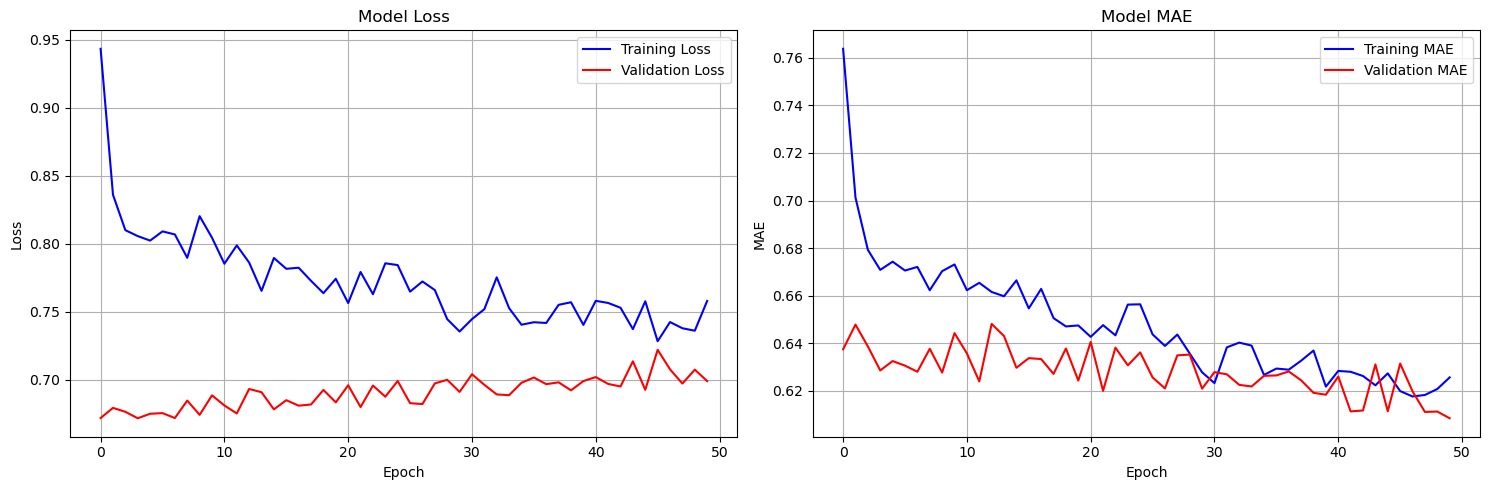

บันทึกกราฟการเรียนรู้: learning_curves.png
กำลังประเมินแบบจำลอง...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
ผลการประเมินแบบจำลอง:
MSE: 11388.8173
MAE: 77.6766
R²: 0.0542
กำลังสร้างกราฟเปรียบเทียบ...


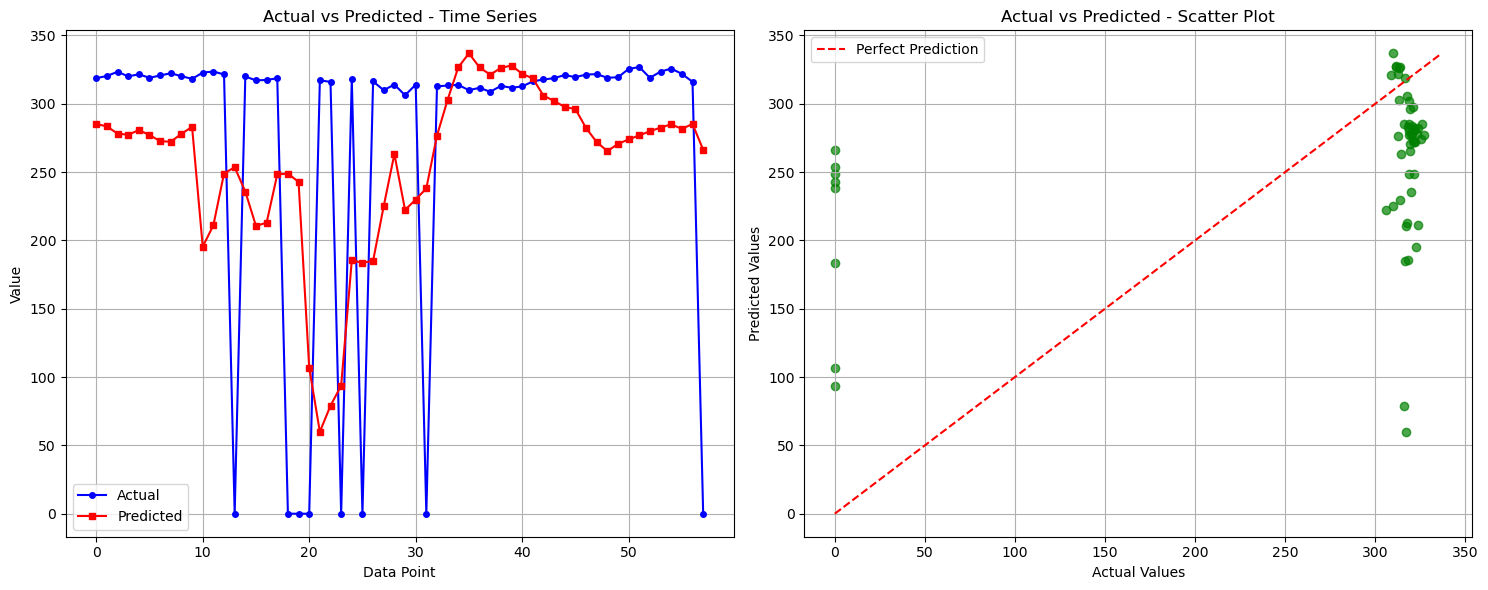

บันทึกกราฟเปรียบเทียบ: prediction_comparison.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
ทำนายสำหรับช่วง 8 วันถัดไป (2025-09-04): 266.34
กำลังสร้างกราฟทำนายอนาคต...


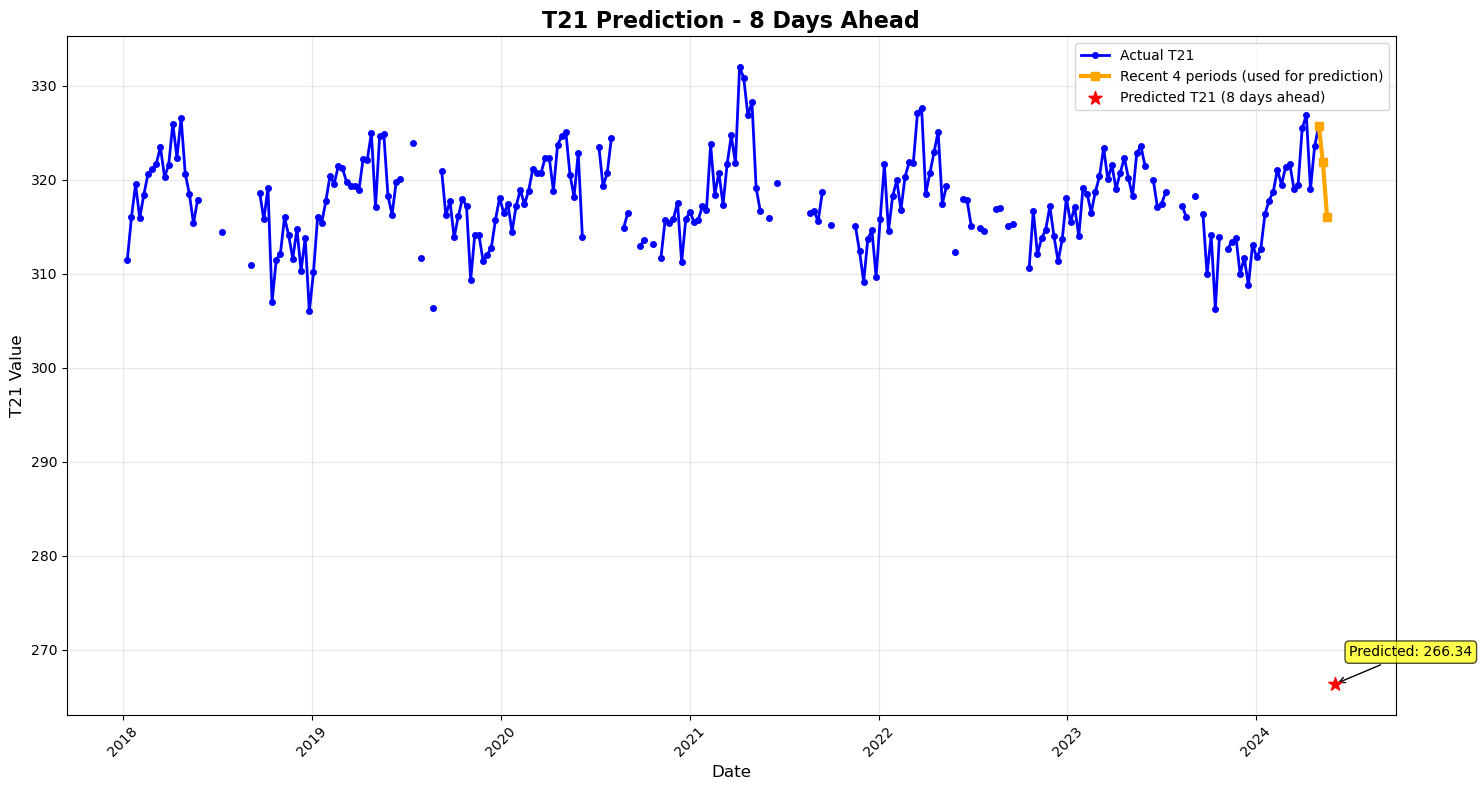

บันทึกกราฟทำนาย: future_prediction.png
กำลังสร้างแผนที่...

🔥 สรุปผลการทำนาย HOTSPOT
📅 วันที่ทำนาย: 2025-09-04
🎯 ค่าทำนาย: 266.34
⚠️  ระดับความเสี่ยง: 🟢 ต่ำ (Low Risk)

📁 ไฟล์ที่สร้างขึ้น:
   • learning_curves.png - กราฟการเรียนรู้
   • prediction_comparison.png - กราฟเปรียบเทียบ
   • future_prediction.png - กราฟทำนายอนาคต
   • comprehensive_analysis.png - กราฟวิเคราะห์รวม
   • hotspot_prediction_map_8day.html - แผนที่แสดงการทำนาย

🌟 การวิเคราะห์เสร็จสมบูรณ์!


In [6]:
# กำหนดพื้นที่ศึกษาที่ใหญ่ขึ้น - ครอบคลุมภาคเหนือ
STUDY_AREA = ee.Geometry.Polygon(
    [[[98.0, 18.0],
    [100.0, 18.0],
    [100.0, 20.0],
    [98.0, 20.0],
    [98.0, 18.0]]])  # ขยายเป็น 2° x 2° ≈ 220x220 km 

# กำหนดช่วงเวลาข้อมูล
start_date = '2018-01-01'
end_date = '2024-06-01'

print("กำลังดึงข้อมูล NDVI รายช่วง 8 วัน...")
ndvi_data = get_8day_ndvi(start_date, end_date, STUDY_AREA)

if ndvi_data is None:
    print("ไม่สามารถดึงข้อมูล NDVI ได้")
    # ขยายพื้นที่ศึกษา
    STUDY_AREA_EXPANDED = ee.Geometry.Polygon(
        [[[98.0, 18.0],
            [99.5, 18.0],
            [99.5, 19.5],
            [98.0, 19.5],
            [98.0, 18.0]]])
    print("ขยายพื้นที่ศึกษา")
    ndvi_data = get_8day_ndvi(start_date, end_date, STUDY_AREA_EXPANDED)
    study_area = STUDY_AREA_EXPANDED
else:
    study_area = STUDY_AREA

if ndvi_data is not None:
    print(f"จำนวนช่วง 8 วันที่มีข้อมูล NDVI: {ndvi_data.size().getInfo()}")
    
    print("กำลังสร้างชุดข้อมูล...")
    dataset = create_dataset(ndvi_data, None, study_area)  # ไม่ใช้ hotspot_data แยก

    if dataset is not None:
        print("กำลังแปลงข้อมูลเป็น DataFrame...")
        df = fc_to_df(dataset)
        print(f"จำนวนข้อมูลใน DataFrame: {len(df)}")

        if not df.empty and len(df) > 10:
            print("ตัวอย่างข้อมูล:")
            print(df.head())
            
            print("กำลังเตรียมข้อมูลสำหรับการฝึก...")
            try:
                X, y, scaler_x, scaler_y = prepare_training_data(df, sequence_length=4)
                print(f"ข้อมูลที่เตรียม: X.shape = {X.shape}, y.shape = {y.shape}")
                
                # แบ่งข้อมูลฝึกและทดสอบ
                split_idx = int(len(X) * 0.8)
                X_train, X_test = X[:split_idx], X[split_idx:]
                y_train, y_test = y[:split_idx], y[split_idx:]

                print(f"ข้อมูลฝึก: {X_train.shape}, ข้อมูลทดสอบ: {X_test.shape}")

                # สร้างและฝึกแบบจำลอง
                print("กำลังสร้างแบบจำลอง...")
                # ใช้ LSTM model
                model = create_lstm_model(X_train.shape[1], X_train.shape[2])
                
                if model is None:
                    print("ไม่สามารถสร้างแบบจำลองได้ กรุณาตรวจสอบการติดตั้ง TensorFlow")
                    raise SystemExit("โปรแกรมหยุดการทำงานเนื่องจากไม่สามารถสร้างแบบจำลองได้")

                print("กำลังฝึกแบบจำลอง...")
                history = model.fit(
                    X_train, y_train,
                    epochs=50,
                    batch_size=8,  # ลด batch size
                    validation_data=(X_test, y_test) if len(X_test) > 0 else None,
                    verbose=0
                )

                # แสดงกราฟการเรียนรู้
                print("กำลังสร้างกราฟการเรียนรู้...")
                plot_learning_curves(history)

                # ประเมินแบบจำลอง
                if len(X_test) > 0:
                    print("กำลังประเมินแบบจำลอง...")
                    y_pred = model.predict(X_test)
                    y_pred_rescaled = scaler_y.inverse_transform(y_pred)
                    y_test_rescaled = scaler_y.inverse_transform(y_test)

                    print("ผลการประเมินแบบจำลอง:")
                    evaluate_model(y_test_rescaled, y_pred_rescaled)

                    # แสดงกราฟเปรียบเทียบ
                    print("กำลังสร้างกราฟเปรียบเทียบ...")
                    plot_prediction_comparison(y_test_rescaled, y_pred_rescaled)

                # ทำนายช่วง 8 วันถัดไป
                last_sequence = X[-1:]
                next_8days_prediction = predict_next_8days(model, last_sequence, scaler_x, scaler_y)

                # แสดงผลการทำนาย
                next_8days_date = (datetime.now() + timedelta(days=8)).strftime('%Y-%m-%d')
                print(f"ทำนายสำหรับช่วง 8 วันถัดไป ({next_8days_date}): {next_8days_prediction:.2f}")

                # แสดงกราฟทำนาย 8 วันถัดไป
                print("กำลังสร้างกราฟทำนายอนาคต...")
                plot_future_prediction(df, next_8days_prediction)

                # สร้างกราฟรวมทั้งหมด
                # if len(X_test) > 0:
                #     print("กำลังสร้างกราฟวิเคราะห์รวม...")
                #     create_comprehensive_plots(history, y_test_rescaled, y_pred_rescaled, 
                #                                 df, next_8days_prediction)

                # สร้างและแสดงแผนที่
                print("กำลังสร้างแผนที่...")
                try:
                    prediction_map = create_prediction_map(next_8days_prediction, study_area, next_8days_date)
                    print(prediction_map)
                    # if prediction_map is not None:
                    #     # บันทึกแผนที่
                    #     prediction_map.save('hotspot_prediction_map_8day.html')
                    #     print("บันทึกแผนที่เรียบร้อยแล้ว: hotspot_prediction_map_8day.html")
                        
                    #     # พยายามแสดงแผนที่ใน Jupyter Notebook
                    #     if not display_map_in_notebook(prediction_map):
                    #         print("เปิดไฟล์ hotspot_prediction_map_8day.html ในเบราว์เซอร์เพื่อดูแผนที่")
                            
                    # else:
                    #     print("ไม่สามารถสร้างแผนที่ได้")
                except Exception as map_error:
                    print(f"ไม่สามารถสร้างแผนที่ได้: {map_error}")

                # สรุปผลการทำนาย
                print("\n" + "="*60)
                print("🔥 สรุปผลการทำนาย HOTSPOT")
                print("="*60)
                print(f"📅 วันที่ทำนาย: {next_8days_date}")
                print(f"🎯 ค่าทำนาย: {next_8days_prediction:.2f}")
                
                # ประเมินระดับความเสี่ยง
                if next_8days_prediction > 350:
                    risk_level = "🔴 สูงมาก (High Risk)"
                elif next_8days_prediction > 320:
                    risk_level = "🟡 ปานกลาง (Medium Risk)"  
                else:
                    risk_level = "🟢 ต่ำ (Low Risk)"
                
                print(f"⚠️  ระดับความเสี่ยง: {risk_level}")
                print("="*60)
                
                # แสดงไฟล์ที่สร้างขึ้น
                print("\n📁 ไฟล์ที่สร้างขึ้น:")
                print("   • learning_curves.png - กราฟการเรียนรู้")
                print("   • prediction_comparison.png - กราฟเปรียบเทียบ")
                print("   • future_prediction.png - กราฟทำนายอนาคต")
                print("   • comprehensive_analysis.png - กราฟวิเคราะห์รวม")
                print("   • hotspot_prediction_map_8day.html - แผนที่แสดงการทำนาย")
                print("\n🌟 การวิเคราะห์เสร็จสมบูรณ์!")

            except Exception as e:
                print(f"เกิดข้อผิดพลาดในการเตรียมข้อมูล: {e}")
        else:
            print("ข้อมูลไม่เพียงพอสำหรับการสร้างแบบจำลอง")
    else:
        print("ไม่สามารถสร้างชุดข้อมูลได้")
else:
    print("ไม่สามารถดึงข้อมูล NDVI ได้")



In [10]:
# show map with folium 
import folium

# config figure height
f = folium.Figure(height=400)

m = folium.Map(location=[18.5, 99.0], zoom_start=6).add_to(f)

m